# Week 10 - Information Theory

In [8]:
print("Hello World!")

Hello World!


In [9]:
import zlib # lzma

text = "Here's some text some text text with repetition"
print(f"Original text {len(text)} bytes: ", text)

text_bytes = text.encode("ascii")
comp = zlib.compress(text_bytes)
print(f"Compressed text {len(comp)} bytes: ", comp)

decomp = zlib.decompress(comp)
print("Decompressed text", decomp.decode('ascii'))

ratio = len(comp) / len(text_bytes)
print(f"Compression Ratio: {ratio:.2f}")

Original text 47 bytes:  Here's some text some text text with repetition
Compressed text 42 bytes:  b'x\x9c\xf3H-JU/V(\xce\xcfMU(I\xad(Ab\x81\x89\xf2\xcc\x92\x0c\x85\xa2\xd4\x82\xd4\x92\xcc\x92\xcc\xfc<\x00\x9b\xcd\x11\xb5'
Decompressed text Here's some text some text text with repetition
Compression Ratio: 0.89


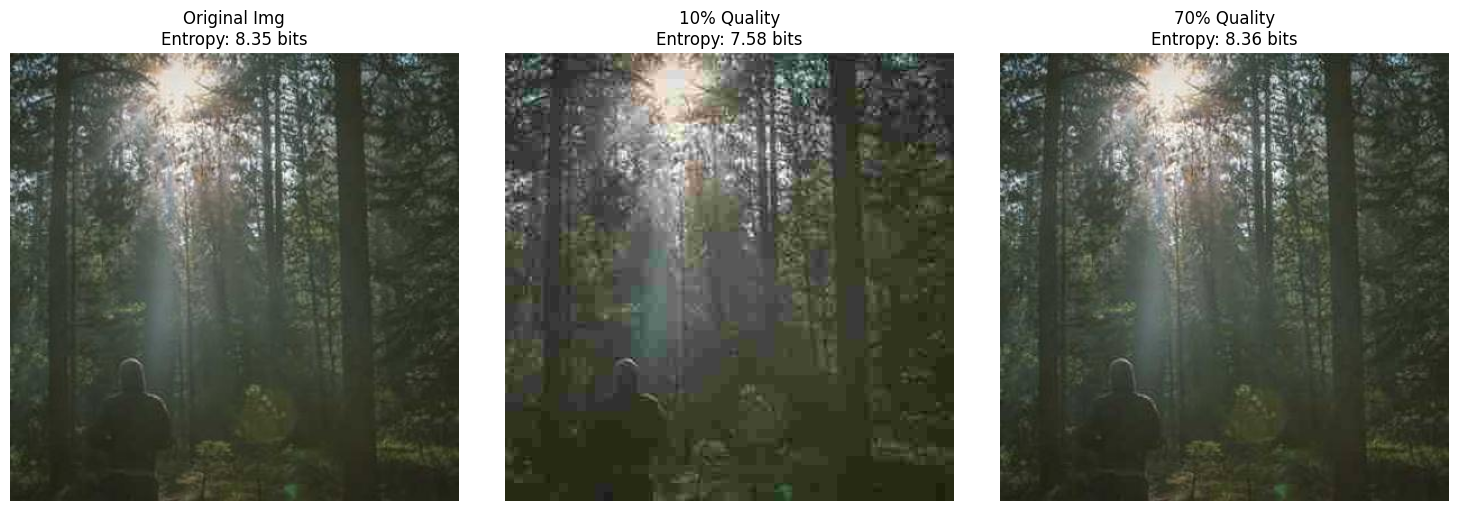

In [10]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

def entropy(img):
    hist = img.histogram()
    probs = [float(h)/sum(hist) for h in hist]
    return -sum(p * np.log2(p) for p in probs if p != 0)

def compress(img, quality=75):
    fname = f'../images/q_{quality}.jpg'
    img.save(fname, 'JPEG', quality=quality)
    compressed = Image.open(fname)
    return compressed, entropy(compressed)

url = "https://picsum.photos/400/400"
response = requests.get(url)
original = Image.open(BytesIO(response.content))

qualities = [10, 70]
images    = [original]
entropies = [entropy(original)]
titles    = ['Original Img']

for q in qualities:
    img_c, img_h = compress(original, q)
    images.append(img_c)
    entropies.append(img_h)
    titles.append(f"{q}% Quality")

plt.figure(figsize=(15,5))
for lcv,(img, entropy, title) in enumerate(zip(images, entropies, titles), start=1):
    plt.subplot(1, len(images), lcv)
    plt.imshow(img)
    plt.title(f"{title}\nEntropy: {entropy:.2f} bits")
    plt.axis('off')

plt.tight_layout()
plt.show()



#Week 11- Network Simulation

In [11]:
%pip install faker tqdm -q
from queue import Queue
from faker import Faker
from time import time, sleep



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
class Device:
    def __init__(self, name):
        self.ip = ""
        self.name = name
        self.inbox = Queue()

    def send(self, recip, msg):
        print(f"{self.name} is sending {len(msg)} bytes to {recip.ip}")
        for _ in tqdm(range(len(msg)), desc="Sending", ncols="100"):
            sleep(0.25) # ~32 bits per second // 4 bytes per second
        recip.inbox.put(msg.encode('ascii'))

    def receive(self):
        if not self.inbox.empty():
            msg = self.inbox.get().decode('ascii')
            print(f"{self.name} received a message: {msg}")
            return len(msg)
        return 0






class Network:
    def __init__(self):
        self.devices = []
        self.dhcp = Faker()
        self.start_time = time()
        self.usage = 0

    def add_device(self, device: Device) -> None:
        device.ip = self.dhcp.ipv4()
        self.devices.append(device)

    def sim_traffic(self):
        for device in self.devices:
            self.usage += device.receive()

    def display(self):
        print(f"Uptime: {time() - self.start_time:.4} seconds")
        print(f"Data usage: {self.usage} bytes")
        print("Connected Devices: ")
        for d in self.devices:
            print(f"{d.name}\t\t  {d.ip}")



In [13]:
alice = Device("Alice")
bob   = Device("Bob")

network: Network = Network()
network.add_device(alice)
network.add_device(bob)
network.display()

while True:
    sender_name = input("Who are you (Alice/Bob)?")
    if sender_name == "Alice" :
        sender, recip = alice, bob
    elif sender_name == "Bob":
        sender, recip = bob, alice
    else:
        print("Invalid name")
        continue
    msg = input("Enter your message: ")
    sender.send(recip, msg)
    network.sim_traffic()

    loop = input("Do you want to send another msg (y/n): ")
    if loop not in "yes":
        break
network.display()


Uptime: 0.008499 seconds
Data usage: 0 bytes
Connected Devices: 
Alice		  2.215.47.197
Bob		  191.35.69.21
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Invalid name
Alice is sending 4 bytes to 191.35.69.21


NameError: name 'tqdm' is not defined

#Week 12 -TCP/IP Model


In [13]:
%pip install faker tqdm termcolor -q
import random
from tqdm import tqdm
from time import sleep
from faker import Faker
from termcolor import colored


2206.07s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
def print_sleep(msg, seconds=1):
    print(msg)
    sleep(seconds)

def do_progress(length, desc, seconds=0.05):
    for _ in tqdm(range(length), desc = desc, ncols=100):
        sleep(seconds)

In [21]:
class ApplicationLayer:
    def __init__(self, data):
        self.data = data

    def prepare_data(self):
        print_sleep(colored("Application Layer: ", "cyan") + f"Preparing data" '{self.data}')
        return self.data.encode()

class TransportLayer:
    def __init__(self, protocol="TCP", port=80):
        self.protocol = protocol
        self.port = port
        self.sequence_num = random.randint(1, 1000)

    def prepare_segment(self, data):
        header = colored("Transport Layer: ", "magenta")
        if self.protocol == "TCP":
            print_sleep(header + f"Using TCP on Port {self.port} - Esablishing connection...")
            #TCP Handshake
            print_sleep(header + f"SYN packet (Seq={self.sequence_num})", 0.5)
            print_sleep(header + f"SYN-ACK packet (Seq={self.sequence_num+1})", 0.5)
            print_sleep(header + f"ACK packet - connection established", 0.5)
        else:
            print(header + "Using UDP on Port {self.port} - No connection setup required.")

        segment = f"{self.protocol}-Port-{self.port}-Segment-{self.sequence_num}|{data.decode()}"
        do_progress(len(segment), "Transport Layer Processing")
        return segment.encode()


class InternetLayer:
    def __init__(self, src_ip, dest_ip):
        self.src_ip  = src_ip
        self.dest_ip = dest_ip

    def prepare_packet(self, segment):
        print_sleep(colored("Internet Layer: ", "yellow") + f"Adding IP Header (Source: {self.src_ip} + Desination: {self.dest_ip}")
        packet = f"IP: {self.src_ip}>{self.dest_ip}|{segment.decode()}"
        do_progress(len(packet), "Internet Layer Processesing")
        return packet.encode()

class NetworkAccessLayer:
    def __init__(self, src_mac, dest_mac):
        self.src_mac  = src_mac
        self.dest_mac = dest_mac

    def prepare_frame(self, packet):
        print_sleep(colored("NetWork Access Layer: ", "green") + f"Adding IP Header (Source: {self.src_mac} + Desination: {self.dest_mac}")
        frame = f"MAC: {self.src_mac}>{self.dest_mac}|{packet.decode()}"
        do_progress(len(frame), "Newtwork Access Layer Processesing")
        return frame.encode()

In [22]:
class InternetDevice:
    def __init__(self, name, ip, mac):
        self.name = name
        self.ip   = ip
        self.mac  = mac

    def send(self, dest_device, data, port=80):
        app_data = ApplicationLayer(data).prepare_data()
        segment  = TransportLayer("TCP").prepare_segment(app_data)
        packet   = InternetLayer(self.ip, dest_device.ip).prepare_packet(segment)
        frame    = NetworkAccessLayer(self.mac, dest_device.mac).prepare_frame(packet)
        print_sleep(f"\n{self.name} is sending data to {dest_device.name} on port {port}")
        dest_device.recive(frame)

    def recive(self, frame):
        print(f"{self.name} recived data: \n {frame.decode()}\n")
        print("Processing data through layers...") # reverse order
        do_progress(5, "Network Access Layer Decapsulation", 0.1)
        split_frame = frame.decode().split("|")
        del split_frame[0] # remove mac header
        do_progress(5, "Network Access Layer Decapsulation", 0.1)
        del split_frame[0] # Remove IP header
        do_progress(5, "Internet Layer Layer Decapsulation", 0.1)
        del split_frame[0] # remove TCP/UDP header
        do_progress(5, "Application Layer Decapsulation", 0.1)
        print(f"data recived:\n{split_frame[0]}")

In [23]:
router = Faker()
device1 = InternetDevice("ComputerA", router.ipv4(), router.mac_address())
device2 = InternetDevice("ComputerB", router.ipv4(), router.mac_address())
device1.send(device2, "Hello From computer A", port=80)

Application Layer: Preparing data{self.data}
Transport Layer: Using TCP on Port 80 - Esablishing connection...
Transport Layer: SYN packet (Seq=827)
Transport Layer: SYN-ACK packet (Seq=828)
Transport Layer: ACK packet - connection established


Transport Layer Processing: 100%|███████████████████████████████████| 45/45 [00:02<00:00, 19.59it/s]


Internet Layer: Adding IP Header (Source: 129.221.247.35 + Desination: 111.206.242.79


Internet Layer Processesing: 100%|██████████████████████████████████| 79/79 [00:04<00:00, 19.62it/s]


NetWork Access Layer: Adding IP Header (Source: 3c:d7:0b:eb:38:af + Desination: 2e:45:d1:79:72:f5


Newtwork Access Layer Processesing: 100%|█████████████████████████| 120/120 [00:06<00:00, 19.62it/s]



ComputerA is sending data to ComputerB on port 80
ComputerB recived data: 
 MAC: 3c:d7:0b:eb:38:af>2e:45:d1:79:72:f5|IP: 129.221.247.35>111.206.242.79|TCP-Port-80-Segment-827|Hello From computer A

Processing data through layers...


Application Layer Decapsulation: 100%|████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]

data recived:
Hello From computer A


In [ ]:
#Week 13
%pip install sympy -q
import sympy

class RSA:
    def __init__(self, p=(-1), q=(-1)):
        p = sympy.randprime(500, 1_000_000) if p == (-1) else p
        q = sympy.randprime(500, 1_000_000) if q == (-1) else q
        self.n = p*q
        self.phi = (p-1)*(q-1)
        self.e = 2
        while sympy.gcd(self.e, self.phi) != 1:
            self.e +=1

        self.d = pow(self.e, -1, self.phi) # (e** (-1)) % phi


    def encrypt(self, msg):
        cipher = [pow(ord(m), self.e, self.n) for m in msg]
        return cipher


    def decrypt(self, cipher):
        msg = "".join([chr(pow(c, self.e, self.n))for c in cipher])
        return msg


In [ ]:
import base64
import numpy as np

rsa = RSA(p=(-61), q=(-53)) # rsa = RSA()

message = input("Enter Message: ")
print("Entered: ", message)
e_msg = rsa.ecnrypt(message)
print("Encrypted: ", e_msg)
print("Encoded: (base64): ", base64.b64encode(np.array(e_msg)))
d_msg = rsa.decrypt(e_msg)
print("Decrypted: ", d_msg)


#Week 14 - Quantum Computing



In [ ]:
%pip install  qiskit qiskit.aer -q
from qiskit import QuantumCircit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector



In [ ]:
qc = QuantumCircit(1, 1) #1 Qubit and 1 classical bit
#The classical but stores the classical output
#apply Hadamard gate (enter superposition)
qc.h(0)
#visualize on a bloch sphere
qc.save_statevector
sim = AerSimulator()
qobj = transpile(qc, sim)
result = sim.run(qobj).result()
statevector = result.get_statevector()
print(statevector)
plot_bloch_multivector(statevector)




In [ ]:
qc.measure([0], [0])
counts = sim.run().results.get_counts()
plot_histogram(counts)


In [ ]:
qc_entangle = QuantumCircit(2, 2)
#create a bell state // entanglement
qc_entangle.h(0) # Superposition
qc_entangle.cx(0, 1) # controlled -NOT [CNOT] gate (entangle)
qc_entangle.measure([0, 1], [0, 1])
qc_entangle.save_statevector()
sim_results = sim.run(qc_entangle).result().get_counts()
plot_histogram(counts)

In [ ]:
statevector = sim_results.get_statevector()
plot_bloch_multivector(statevector)

# Week 21 - SQL


In [14]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("prog54a.db")
cur = conn.cursor()

In [17]:
cur.execute("""
    CREATE TABLE cars (
        Vehicle TEXT,
        Miles   INT,
        Gallons INT,
        Mpg     FLOAT
    )

""")

OperationalError: table cars already exists

In [ ]:
data = [
    ('1970 VW Bug',   286,  9),
    ('1979 Firebird', 412, 40),
    ("1980 Subaru",   361, 18),
    ('1975 Cutlass',  161, 11)
]
cur.executemany('INSERT INTO cars (Vehicle, Miles, Gallons, Mpg) VALUES (?, ?, ?, 0)', data)
conn.commit()

In [ ]:
df = pd.read_sql_query('SELECT * FROM cars', conn)
df

In [ ]:
#MPG for each car and update table
for index, row in df.iterrows():
    mpg = round(row['Miles'] / row['Gallons'], 1)
    cur.execute('UPDATE cars SET Mpg = ? WHERE Vehicle = ?', (mpg, row['Vehicle']))

cur.execute('DELETE FROM cars WHERE Mpg < 12 AND Gallons = 40')
conn.commit()

In [ ]:
updated_df = pd.read_sql_query("SELECT * FROM cars", conn)
#close connections to db
cur.close()
conn.close()
updated_df

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x=df['Miles'], y=df['Vehicle'])
plt.title('Miles Driven in one month per Vehicle')